# Temperature dependent elastic constants

## Background

$$C_{ijkl} = \frac{1}{V} \frac{\partial^2 U}{\partial \varepsilon_{ij}\partial \varepsilon_{kl}}$$

$$U(T) = \frac{V}{2}C_{ijkl}(T)\varepsilon_{ij}\varepsilon_{kl}$$

$$\sigma_{ij} = C_{ijkl}{\varepsilon_{kl}}$$

### How to get $U$ or $\sigma$

- MD
- Quasi-Harmonic

## Tasks

- Get $a_0$ from potential
- Lattice parameter (as a function of T)
  - MD
    - NVT
    - NPT
  - QH
- Calculate $U$ or $\sigma$ for various $\varepsilon$
  - MD: Equilibriate and average with LAMMPS
  - QH: Get strains from Yuriy's tool and run phonopy
- Fit

## Teams

- MD: Erik, Han, (Raynol), Prabhath, Jan, Sriram
- QH: Raynol, (Sam), Bharathi, Ahmed, Haitham
- Fit & Yuriy: Sam
- Literature

# Implementation

* https://atomistics.readthedocs.io/en/latest/bulk_modulus_with_gpaw.html#elastic-matrix
* https://github.com/pyiron/atomistics/blob/main/tests/test_elastic_lammpslib_functional.py
* https://github.com/pyiron/pyiron_workflow_atomistics/blob/interstitials/pyiron_workflow_atomistics/dataclass_storage.py
* https://github.com/ligerzero-ai/pyiron_workflow_lammps/blob/main/pyiron_workflow_lammps/engine.py#L21

## Reference

We compare our values with the paper - [M. Krief, et. al., Physical Review E, 103, 063307, 2021](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.103.063307#s4)

Potential used: Copper [Mishin potential](https://www.ctcms.nist.gov/potentials/entry/2001--Mishin-Y-Mehl-M-J-Papaconstantopoulos-D-A-et-al--Cu-1/)

## Imports

In [1]:
from ase.build import bulk
from ase.atoms import Atoms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import annotations

from atomistics.workflows.elastic.workflow import (
    get_tasks_for_elastic_matrix,
    analyse_results_for_elastic_matrix
)

from atomistics.calculators import (
    evaluate_with_lammpslib, 
    get_potential_by_name, 
    calc_molecular_dynamics_npt_with_lammpslib, 
    calc_molecular_dynamics_nvt_with_lammpslib
)

from atomistics.calculators.lammps.libcalculator import (
    calc_static_with_lammpslib, 
    calc_molecular_dynamics_langevin_with_lammpslib
)

/cmmc/ptmp/pchilaka/Packages/atomistics/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


In [3]:
calc_molecular_dynamics_langevin_with_lammpslib??

Signature:
calc_molecular_dynamics_langevin_with_lammpslib(
    structure: 'Atoms',
    potential_dataframe: 'pandas.DataFrame',
    run: 'int' = 100,
    thermo: 'int' = 100,
    timestep: 'float' = 0.001,
    Tstart: 'float' = 100.0,
    Tstop: 'float' = 100,
    Tdamp: 'float' = 0.1,
    seed: 'int' = 4928459,
    dist: 'str' = 'gaussian',
    disable_initial_velocity: 'bool' = False,
    lmp=None,
    output_keys=('positions', 'cell', 'forces', 'temperature', 'energy_pot', 'energy_tot', 'pressure', 'velocities', 'volume'),
    **kwargs,
)
Docstring: <no docstring>
Source:   
def calc_molecular_dynamics_langevin_with_lammpslib(
    structure: Atoms,
    potential_dataframe: pandas.DataFrame,
    run: int = 100,
    thermo: int = 100,
    timestep: float = 0.001,
    Tstart: float = 100.0,
    Tstop: float = 100,
    Tdamp: float = 0.1,
    seed: int = 4928459,
    dist: str = "gaussian",
    disable_initial_velocity: bool = False,
    lmp=None,
    output_keys=OutputMolecularDynamic

In [4]:
from pyiron_base import Project, job

In [5]:
pr = Project("Finite_temp_convergence_on_loginnode")

## Create bulk sample with a guessed lattice constant

In [6]:
unit_cell = bulk('Cu', 'fcc', a=3.6514, cubic=True) # 4 atoms

In [7]:
repeated_unit_cell = unit_cell.repeat(5) # 500 atoms

In [8]:
potential_name_str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"

potential_df = get_potential_by_name(
    potential_name=potential_name_str
)

## 0K Relaxed Structure

In [9]:
def get_relaxed_structure_at_0K(
        structure: Atoms, 
        potential: str, 
        lmp_optimizer_kwargs : dict = None
        ) -> Atoms:
    
    df_pot_selected = get_potential_by_name(
        potential_name=potential
        )
    
    result_dict = evaluate_with_lammpslib(
        task_dict={"optimize_positions_and_volume": structure},
        potential_dataframe=df_pot_selected,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
        )
    
    structure_relaxed = result_dict['structure_with_optimized_positions_and_volume']

    return structure_relaxed

In [10]:
lmp_optimizer_kwargs={
    'min_style':'cg',
    'ionic_force_tolerance':1e-8,
    'pressure':np.zeros(6) # add anisotropy
}

In [11]:
relaxed_unit_cell = get_relaxed_structure_at_0K(
    unit_cell, # 4 atoms
    potential_name_str, 
    lmp_optimizer_kwargs
)

relaxed_unit_cell # 4 atoms

Atoms(symbols='Cu4', pbc=True, cell=[3.61500008107858, 3.61500008107858, 3.6150000810785805])

## 0K Lattice Constant

In [12]:
def get_lattice_constant_at_0K(
        structure: Atoms, 
        potential: str, 
        lmp_optimizer_kwargs : dict = None
        ) -> float:

    structure_relaxed = get_relaxed_structure_at_0K(
        structure=structure, 
        potential=potential,
        lmp_optimizer_kwargs=lmp_optimizer_kwargs
    )
    
    a_0 = structure_relaxed.get_volume()**(1/3)

    return a_0 # Angstrom

In [13]:
a_0 = get_lattice_constant_at_0K(
    structure=unit_cell, 
    potential=potential_name_str,
    lmp_optimizer_kwargs=lmp_optimizer_kwargs)

a_0 # Angstrom

np.float64(3.61500008107858)

We get the same lattice constant at 0K as the reference paper!

## 0K Elastic Constants

In [14]:
def get_strain_tensor_cubic(
        structure : Atoms, 
        strain : float = 0.005
    ) -> dict:

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    return deformation_gradient_dict

In [15]:
def get_elastic_constants_from_stress_tensor(
        tensor_dict : dict, 
        strain : float
    ) -> list[float]:

    elastic_constants_list = []

    for constant_str, diff in tensor_dict.items():
        if constant_str == 'C11':
            constant = diff[0, 0] / strain
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C12':
            sigma33 = diff[2, 2]
            constant = (sigma33/ strain) / 2
            elastic_constants_list.append(abs(constant))

        elif constant_str == 'C44':
            sigma23 = diff[2, 1]
            constant = sigma23 / (2 * strain)
            elastic_constants_list.append(abs(constant))

    return elastic_constants_list

In [16]:
def get_stress_tensor_at_0K(
        structure : Atoms, 
        potential_dataframe : pd.DataFrame, 
        deformation_gradient : np.array
    ):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(
        strained_cell, 
        scale_atoms=True
    )
    
    relaxed_dict = calc_static_with_lammpslib(
        structure=structure, 
        potential_dataframe=potential_dataframe
    )
    strained_dict = calc_static_with_lammpslib(
        structure=structure_strained,
        potential_dataframe=potential_dataframe
    )

    relaxed_dict['stress_GPa'] = relaxed_dict['stress'] / 10**4
    strained_dict['stress_GPa'] = strained_dict['stress'] / 10**4

    stress_diff = strained_dict['stress_GPa'] - relaxed_dict['stress_GPa']
    
    return stress_diff, relaxed_dict, strained_dict

In [17]:
def calculate_elastic_constants_at_0K(
        structure : Atoms, 
        potential_name : str,
        strain : float = 0.005
    ):

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    deformation_gradient_dict = get_strain_tensor_cubic(
        structure=structure, 
        strain=strain
    )
    
    tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_dict, strained_dict = get_stress_tensor_at_0K(
            structure=structure,
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient
        )
        
        tensor_dict[constant_str] = diff
        tensor_dict[f'relaxed_dict_{constant_str}'] = relaxed_dict
        tensor_dict[f'strained_dict_{constant_str}'] = strained_dict
    
    elastic_constants_list = get_elastic_constants_from_stress_tensor(
        tensor_dict=tensor_dict, 
        strain=strain
    )

    return elastic_constants_list, tensor_dict

## Reference function to fit elastic constants (Jan + Yury)'s

Requires only `relaxed_unit_cell` and `potential_name_str` from previous cells

In [18]:
def fit_elastic_constants(
        structure: Atoms, 
        potential: str, 
        strains, 
        stresses=None, 
        energies=None):

    task_dict, sym_dict = get_tasks_for_elastic_matrix(
        structure=structure,
        eps_range=0.005,
        num_of_point=5,
        zero_strain_job_name="s_e_0",
        sqrt_eta=True
    )

    potential_df = get_potential_by_name(
        potential_name=potential
    )

    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_df,
    )
    
    elastic_dict, sym_dict = analyse_results_for_elastic_matrix(
        output_dict=result_dict,
        sym_dict=sym_dict,
        fit_order=2,
        zero_strain_job_name="s_e_0",
    )

    return elastic_dict

In [19]:
elastic_dict = fit_elastic_constants(
    structure=relaxed_unit_cell,
    potential=potential_name_str,
    strains=None
)

In [20]:
elastic_dict['elastic_matrix']

array([[169.74837327, 123.55258251, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 169.74837327, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 123.55258251, 169.74837327,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  76.24914297,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.24914297,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  76.24914297]])

In [21]:
elastic_constants_list_reference = [
    elastic_dict['elastic_matrix'][0,0], 
    elastic_dict['elastic_matrix'][0,1], 
    elastic_dict['elastic_matrix'][3,3]
    ]

np.round(elastic_constants_list_reference, 1) # GPa

array([169.7, 123.6,  76.2])

In comparison with the [reference paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.103.063307#s4 "M. Krief, et. al., Physical Review E, 103, 063307, 2021"),

$C_{11}$=169.9GPa, $C_{12}$=122.6GPa, and $C_{44}$=76.2GPa

## Finite Temperature equlibiration
* First run NPT to relax volume
* Then equilibriate the cell by running NVT

In [22]:
def equilibriate_structure_at_finite_temperature(
        structure : Atoms, 
        potential : str, 
        temperature : float = 500,
        run : int = 100000,
        thermo : int = 100,
        seed : int = 4928459, 
        cell_scale_value : int = 5,
        thermostat : str = 'langevin'
    ) -> Atoms:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )
    
    structure_repeated = structure.repeat(cell_scale_value)

    npt_dict = calc_molecular_dynamics_npt_with_lammpslib(
        structure=structure_repeated,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=run,
        thermo=thermo,
        seed=seed
    )
    
    npt_lattice_constant = (np.mean(npt_dict['volume'][20:]/len(structure_repeated))*len(structure))**(1/3)
    
    # FIXME: Make it for a generic element - something might be wrong here. Need to check error propagation
    # structure_npt = bulk('Cu', a=npt_lattice_constant, cubic=True)
    # structure_repeated_npt = structure_npt.repeat(cell_scale_value)
    
    structure_repeated_npt = structure.copy()
    structure_repeated_npt.set_cell(
        [[npt_lattice_constant,0,0], 
         [0,npt_lattice_constant,0], 
         [0,0,npt_lattice_constant]],
        scale_atoms = True
    )
    structure_repeated_npt = structure_repeated_npt.repeat(cell_scale_value)

    if thermostat == 'nose-hoover':
        nvt_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure_repeated_npt,
            potential_dataframe=df_pot_selected,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed
        )
        
    elif thermostat == 'langevin':
        nvt_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure_repeated_npt,
            potential_dataframe=df_pot_selected,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed
        )
        
    structure_repeated_nvt = structure_repeated_npt.copy()
    structure_repeated_nvt.set_cell(
        nvt_dict['cell'][-1]
    )
    structure_repeated_nvt.set_positions(
        nvt_dict['positions'][-1]
    )
    structure_repeated_nvt.set_velocities(
        nvt_dict['velocities'][-1]
    )

    return structure_repeated_nvt

## Temperature-dependent Elastic Constants

In [23]:
def get_stress_tensor_at_finite_temperature(
        structure : Atoms, 
        potential_dataframe : pd.DataFrame, 
        deformation_gradient : np.array, 
        temperature : float,
        run : int, 
        thermo : int,
        seed : int,
        thermostat : str
    ):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(
        strained_cell, 
        scale_atoms=True
    )
    
    if thermostat == 'nose-hoover':
        relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
        strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(
            structure=structure_strained, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
    
    elif thermostat == 'langevin':
        relaxed_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )
        strained_dict = calc_molecular_dynamics_langevin_with_lammpslib(
            structure=structure_strained, 
            potential_dataframe=potential_dataframe,
            Tstart=temperature,
            Tstop=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            disable_initial_velocity=True
        )

    relaxed_dict['pressure_GPa'] = relaxed_dict['pressure'] / 10**4
    strained_dict['pressure_GPa'] = strained_dict['pressure'] / 10**4

    stress_diff = -np.mean(strained_dict['pressure_GPa'][20:] - relaxed_dict['pressure_GPa'][20:], axis=0)

    return stress_diff, relaxed_dict, strained_dict

In [24]:
def calculate_elastic_constants_at_finite_temperature(
        structure : Atoms, # change to unit cell
        cell_scale_value : int,
        potential_name : str, 
        temperature : float = 0, 
        strain : float = 0.005,
        run : int = 10000,
        thermo : int = 100, 
        seed : int = 42, 
        thermostat : str = 'langevin'
    ):

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    equilibriated_structure = equilibriate_structure_at_finite_temperature(
        structure=structure,
        potential=potential_name_str, 
        temperature=temperature, 
        seed=seed,
        cell_scale_value=cell_scale_value
    )
    
    deformation_gradient_dict = get_strain_tensor_cubic(
        structure=equilibriated_structure, 
        strain=strain
    )
    
    tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_dict, strained_dict = get_stress_tensor_at_finite_temperature(
            structure=equilibriated_structure, 
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient,
            temperature=temperature,
            run=run,
            thermo=thermo,
            seed=seed,
            thermostat=thermostat
        )
        
        tensor_dict[constant_str] = diff
        tensor_dict[f'relaxed_dict_{constant_str}'] = relaxed_dict
        tensor_dict[f'strained_dict_{constant_str}'] = strained_dict
    
    elastic_constants_list = get_elastic_constants_from_stress_tensor(
        tensor_dict=tensor_dict, 
        strain=strain
    )

    return elastic_constants_list, tensor_dict

## Convergence tests

In [25]:
import json
import hashlib

def hash_dict(d, algo='md5'):
    params_str = json.dumps(d, sort_keys=True)
    hash_func = getattr(hashlib, algo)
    return hash_func(params_str.encode('utf-8')).hexdigest()

In [26]:
input_params_scale = {
    "cell_scale_value" : [3, 5, 7, 9],
    "run" : [5000, 10000, 20000],
    "temperature" : [500],
    "strain" : [0.0001],
    "seed": [1357],
    "thermostat" : ["langevin"]
}

In [28]:
from itertools import product
keys = input_params_scale.keys()
values = input_params_scale.values()

for combo in product(*values):
    params = dict(zip(keys, combo))
    print(params)

{'cell_scale_value': 3, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 3, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 5, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 7, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 7, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
{'cell_scale_value': 7, 'run': 20000, 'temperature': 500, 'strain': 0.0001,

In [46]:
def run_convergence(structure, potential_name_str, input_params, project):

    from itertools import product
    import os
    
    keys = input_params.keys()
    values = input_params.values()

    results = []
    for combo in product(*values):
        params = dict(zip(keys, combo))
        print('\n')
        print(params)
        hash = hash_dict(params)
        
        if os.path.isfile(f"{project.path}/results_{hash}.pkl"):
            print('Already has been run')
            print('Loading pickled df')
            results.append(pd.read_pickle(f"{project.path}/results_{hash}.pkl").iloc[[-1]].iloc[0].to_dict())
            continue
        
        elastic_constants_list, tensor_dict = calculate_elastic_constants_at_finite_temperature(
            structure = structure,
            potential_name = potential_name_str,
            **params
        )

        temp_result = {
            "elastic_constants": elastic_constants_list,
            "tensor_dict": tensor_dict,
            "structure": structure,
            "potential_name" : potential_name_str,
            "input_params": params
        }

        temp_results_df = pd.DataFrame(temp_result)
        temp_results_df.to_pickle(f"{project.path}/results_{hash}.pkl")

        results.append(temp_result)
        
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f"{project.path}/results_all.pkl")

    return results_df

In [47]:
results_df = run_convergence(
    structure=relaxed_unit_cell,
    potential_name_str=potential_name_str,
    input_params = input_params_scale,
    project = pr
)



{'cell_scale_value': 3, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 3, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 3, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 5, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 5, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 5, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}
Already has been run
Loading pickled df


{'cell_scale_value': 7, 'run': 5000, 'temperature': 

In [41]:
results_df

,elastic_constants,tensor_dict,structure,potential_name,input_params
0,"[157.80655843702144, 203.74599579507813, 67.06815829128631]","{'C11': [[0.015780655843702144, 6.1357667728798774e-06, -6.0453607681161134e-05], [6.1357667728798774e-06, 0.011658592026782355, -4.0903593608576476e-05], [-6.0453607681161134e-05, -4.090359360857...","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 3, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
1,"[55.99756367497742, 121.77641895697452, 16.830661553012764]","{'C11': [[0.005599756367497742, 0.006515358865132798, -0.00033420411829100156], [0.006515358865132798, 0.03670360454386373, -0.020404265274293946], [-0.00033420411829100156, -0.020404265274293946,...","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 3, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
2,"[336.4420006003439, 9.130226113949174, 2.889296915984925]","{'C11': [[-0.033644200060034386, 0.008484583841194467, -0.011234714912053096], [0.008484583841194467, -0.0012502441216821897, -0.0134247106701357], [-0.011234714912053096, -0.0134247106701357, -0....","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 3, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
3,"[72.61801457557864, 8.747185661108487, 164.549893844669]","{'C11': [[-0.007261801457557865, -0.0535476138982935, 0.0028943219816679315], [-0.0535476138982935, -0.02285195156196052, 0.015274505417882807], [0.0028943219816679315, 0.015274505417882807, -0.00...","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 5, 'run': 5000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
4,"[12.43236780101992, 234.6988190048664, 34.78244864256556]","{'C11': [[-0.0012432367801019921, -0.03739072904659941, 0.004858566380618322], [-0.03739072904659941, 0.001610954930511884, 0.00912531592491048], [0.004858566380618322, 0.00912531592491048, 0.0341...","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 5, 'run': 10000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
5,"[115.11100680825328, 205.51781877404872, 66.81596030309132]","{'C11': [[0.011511100680825328, -0.02895767451381075, 0.0030705058476428065], [-0.02895767451381075, 0.021485808835548688, 0.004357495021841485], [0.0030705058476428065, 0.004357495021841485, 0.04...","(Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...",2001--Mishin-Y--Cu-1--LAMMPS--ipr1,"{'cell_scale_value': 5, 'run': 20000, 'temperature': 500, 'strain': 0.0001, 'seed': 1357, 'thermostat': 'langevin'}"
6,"[164.75239654990705, 36.25172895641562, 116.81471991439919]","{'C11': [[0.016475239654990707, 0.008648522256256928, 0.0016747634917063333], [0.008648522256256928, -0.03015513636578194, 0.005432858772316422], [0.

### Results dataframe

In [48]:
results_df['cell_scale_value'] = results_df['input_params'].apply(lambda x: x.get('cell_scale_value'))
results_df['run'] = results_df['input_params'].apply(lambda x: x.get('run'))

In [49]:
results_df['n_atoms'] = ((results_df['cell_scale_value'])**3) * 4

In [51]:
results_df[['C11', 'C12', 'C44']] = pd.DataFrame(results_df['elastic_constants'].tolist(), index=results_df.index)

In [52]:
results_df.iloc[0]

elastic_constants                                                                                                                                                [157.80655843702144, 203.74599579507813, 67.06815829128631]
tensor_dict          {'C11': [[0.015780655843702144, 6.1357667728798774e-06, -6.0453607681161134e-05], [6.1357667728798774e-06, 0.011658592026782355, -4.0903593608576476e-05], [-6.0453607681161134e-05, -4.090359360857...
structure            (Atom('Cu', [np.float64(0.018199959460699095), np.float64(0.018199959460699095), np.float64(0.018199959460699095)], index=0), Atom('Cu', [np.float64(0.01819995946069909), np.float64(1.825699999999...
potential_name                                                                                                                                                                            2001--Mishin-Y--Cu-1--LAMMPS--ipr1
input_params                                                                                              {'cell_sca

### Plots

In [56]:
import seaborn as sns

#### Dependence of elastic constants on size scaling and number of MD steps

In [57]:
results_melted = results_df.melt(id_vars=['n_atoms', 'run'], value_vars=['C11', 'C12', 'C44'],
                                 var_name='Elastic Constant', value_name='Value')

In [58]:
results_melted

,n_atoms,run,Elastic Constant,Value
0,108,5000,C11,157.806558
1,108,10000,C11,55.997564
2,108,20000,C11,336.442001
3,500,5000,C11,72.618015
4,500,10000,C11,12.432368
5,500,20000,C11,115.111007
6,1372,5000,C11,164.752397
7,1372,10000,C11,159.101063
8,1372,20000,C11,82.347413
9,2916,5000,C11,334.200657


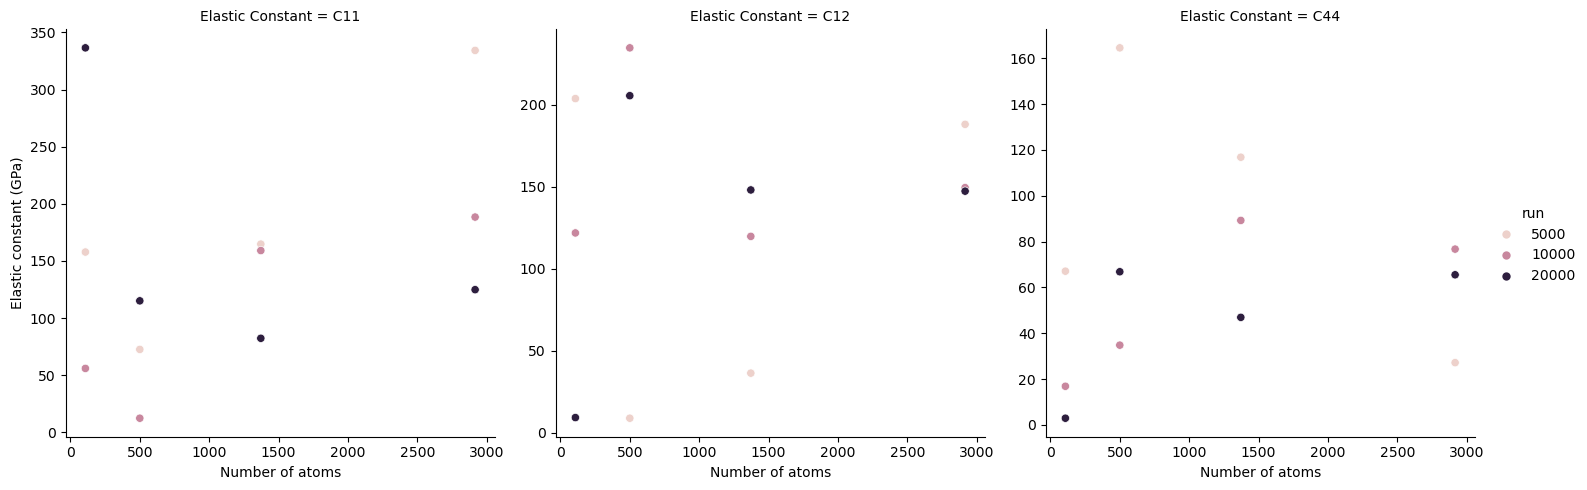

In [60]:
g = sns.relplot(data=results_melted, x='n_atoms', y='Value', hue='run', col='Elastic Constant', kind='scatter', facet_kws={'sharey': False})
g.set_axis_labels('Number of atoms', 'Elastic constant (GPa)')
plt.show()